# Подготовка датасета

## Имортируем зависимости

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

## Описание параметров


**title** (string): Текстовое название фильма.

**genres** (list of strings): Список жанров, к которым относится фильм.

**release_date** (datetime): Дата, когда фильм был выпущен.

**runtime** (integer): Длительность фильма в минутах.

**budget** (integer): Бюджет, выделенный на производство фильма. Может отсутствовать для некоторых фильмов.

**revenue** (integer):  Сумма сборов фильма в прокате. Может отсутствовать для некоторых фильмов.

**director** (string):  Имя режиссера фильма. Может отсутствовать или содержать имя первого члена съемочной группы, если информация о режиссере недоступна.

**popularity** (float): Рейтинг популярности фильма, рассчитанный TMDB.

**vote_average** (float): Средняя оценка фильма, выставленная пользователями.

**vote_count** (integer): Количество оценок, поставленных пользователями.

**overview** (string): Краткое описание сюжета фильма.

## Выводим исходный датасет

In [107]:
df = pd.read_csv('tmdb_movies_2.csv',  lineterminator='\n')
df

,title,genres,release_date,runtime,budget,revenue,director,popularity,vote_average,vote_count,overview
0,Terrifier 3,"['Horror', 'Thriller', 'Mystery']",2024-10-09,125,2000000,59156753,Brad Miska,6883.159,7.300,601,Five years after surviving Art the Clown's Hal...
1,Venom: The Last Dance,"['Science Fiction', 'Action', 'Adventure']",2024-10-22,109,120000000,310000000,David Michelinie,5590.757,6.696,479,Eddie and Venom are on the run. Hunted by both...
2,The Wild Robot,"['Animation', 'Science Fiction', 'Family']",2024-09-12,102,78000000,269785520,Dean DeBlois,4321.421,8.546,2392,"After a shipwreck, an intelligent robot called..."
3,The Substance,"['Drama', 'Horror', 'Science Fiction']",2024-09-07,141,17500000,42776354,Anne Juin,2881.789,7.319,1384,Have you ever dreamt of a better version of yo...
4,Joker: Folie à Deux,"['Drama', 'Crime', 'Thriller']",2024-10-01,138,195000000,200714058,Bill Finger,2614.505,5.682,1350,"While struggling with his dual identity, Arthu..."
...,...,...,...,...,...,...,...,...,...,...,...
5975,Manhattan Murder Mystery,"['Comedy', 'Mystery']",1993-05-02,104,13500000,11285588,Woody Allen,19.251,7.277,1061,A middle-aged couple suspects foul play when t...
5976,From Hell,"['Horror', 'Mystery', 'Thriller']",2001-02-08,122,35000000,74558115,Albert Hughes,19.249,6.695,2767,Frederick Abberline is an opium-huffing inspec...
5977,Playing It Cool,"['Comedy', 'Romance']",2014-09-26,94,0,1323415,Chris Shafer,19.247,5.877,741,A young man meets and instantly falls in love ...
5978,Abduction,"['Thriller', 'Action', 'Mystery']",2011-09-22,106,35000000,82087155,Robert Jackson,19.247,5.866,2853,"For many years, Nathan Harper has had the unea..."


In [108]:
df = df.drop(['release_date', 'title', 'overview', 'runtime'], axis=1)

## Удаляем нулевые значения и дубликаты

In [109]:
df.isnull().sum()

,0
genres,0
budget,0
revenue,0
director,36
popularity,0
vote_average,0
vote_count,0


In [110]:
df.replace('<null>', np.nan, inplace=True)

In [111]:
df.dropna(inplace=True)

In [112]:
df.isnull().sum()

,0
genres,0
budget,0
revenue,0
director,0
popularity,0
vote_average,0
vote_count,0


In [113]:
duplicated = df.duplicated().sum()
print(duplicated)

0


In [114]:
df = df.drop_duplicates()
df.shape

(5944, 7)

## Разбираемся с выбросами

In [115]:
df.describe()

,budget,revenue,popularity,vote_average,vote_count
count,5.944000e+03,5.944000e+03,5944.000000,5944.000000,5944.000000
mean,2.747258e+07,9.207675e+07,56.902595,6.402386,2423.200538
std,4.791597e+07,1.968138e+08,170.511905,1.492520,3896.977977
min,0.000000e+00,0.000000e+00,19.245000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,23.408250,6.000000,101.000000
50%,4.500000e+06,1.020000e+07,30.710500,6.631000,900.000000
75%,3.500000e+07,9.851011e+07,48.901500,7.228250,3035.250000
max,4.600000e+08,2.923706e+09,6883.159000,10.000000,36482.000000


In [116]:
df.eq(0).sum()

,0
genres,0
budget,2475
revenue,2282
director,0
popularity,0
vote_average,186
vote_count,186


In [117]:
columns_to_check = ['budget', 'revenue', 'vote_average', 'vote_count']
df = df[~(df[columns_to_check] == 0).any(axis=1)]
df.shape

(3204, 7)

In [118]:
df.eq(0).sum()

,0
genres,0
budget,0
revenue,0
director,0
popularity,0
vote_average,0
vote_count,0


## Меняем категориальные переменные на числовые

In [119]:
df = df.drop(['director', 'genres'], axis=1)
df.shape

(3204, 5)

# Анализ датасета

## Бюджет

(array([662., 511., 374., 303., 232., 167., 114., 113., 123.,  84.,  84.,
         52.,  13.,  49.,  38.,  28.,  58.,  25.,  14.,  38.,  14.,  57.,
          5.,   5.,   5.,   1.,   2.,  16.,   3.,   1.,   0.,   1.,   5.,
          0.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.]),
 array([5.00000000e+00, 9.20000490e+06, 1.84000048e+07, 2.76000047e+07,
        3.68000046e+07, 4.60000045e+07, 5.52000044e+07, 6.44000043e+07,
        7.36000042e+07, 8.28000041e+07, 9.20000040e+07, 1.01200004e+08,
        1.10400004e+08, 1.19600004e+08, 1.28800004e+08, 1.38000004e+08,
        1.47200003e+08, 1.56400003e+08, 1.65600003e+08, 1.74800003e+08,
        1.84000003e+08, 1.93200003e+08, 2.02400003e+08, 2.11600003e+08,
        2.20800003e+08, 2.30000002e+08, 2.39200002e+08, 2.48400002e+08,
        2.57600002e+08, 2.66800002e+08, 2.76000002e+08, 2.85200002e+08,
        2.94400002e+08, 3.03600002e+08, 3.12800002e+08, 3.22000002e+08,
        3.

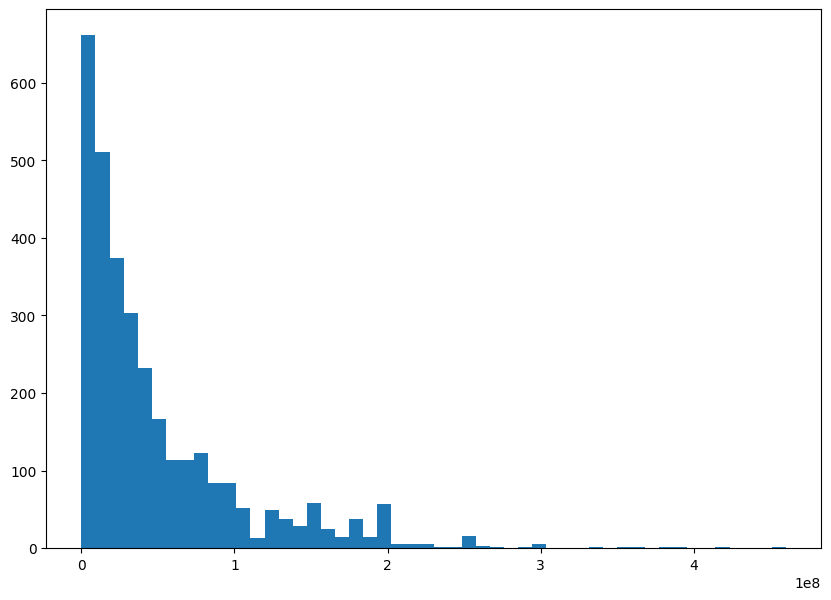

In [120]:
plt.figure(figsize=(10,7))
plt.hist(df['budget'], bins=50)

## Сборы

(array([1.306e+03, 5.760e+02, 3.910e+02, 2.460e+02, 1.460e+02, 1.170e+02,
        1.010e+02, 5.600e+01, 4.500e+01, 3.400e+01, 2.800e+01, 1.900e+01,
        2.400e+01, 2.100e+01, 1.600e+01, 1.200e+01, 1.300e+01, 9.000e+00,
        1.000e+01, 7.000e+00, 1.000e+00, 4.000e+00, 4.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.00000000e+00, 5.84741215e+07, 1.16948242e+08, 1.75422362e+08,
        2.33896483e+08, 2.92370604e+08, 3.50844724e+08, 4.09318844e+08,
        4.67792965e+08, 5.26267086e+08, 5.84741206e+08, 6.43215326e+08,
        7.01689447e+08, 7.60163568e+08, 8.18637688e+08, 8.77111808e+08,
        9.35585929e+08, 9.94060050e+08, 1.05253417e+09, 1.11100829e+09,
        1.169482

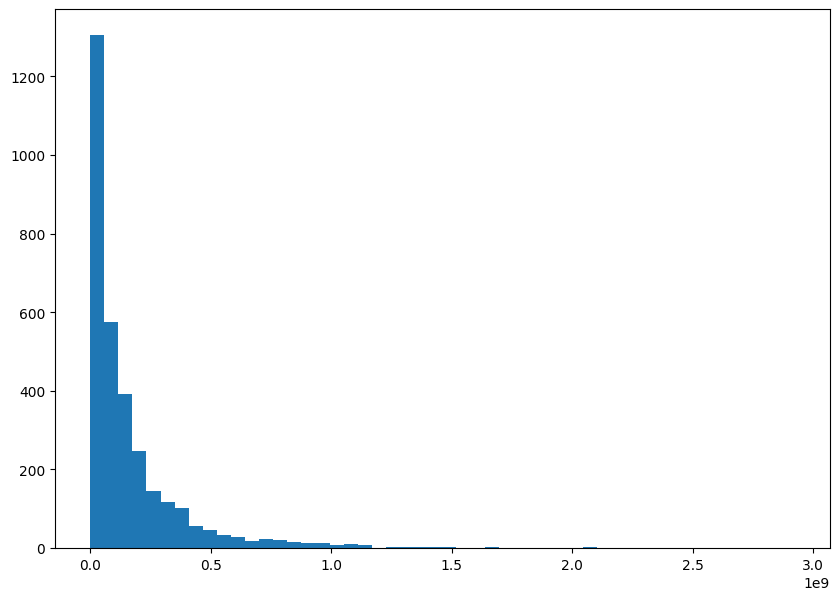

In [121]:
plt.figure(figsize=(10,7))
plt.hist(df['revenue'], bins=50)

## Популярность

(array([3.155e+03, 2.600e+01, 5.000e+00, 3.000e+00, 3.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([  19.247  ,  293.80348,  568.35996,  842.91644, 1117.47292,
        1392.0294 , 1666.58588, 1941.14236, 2215.69884, 2490.25532,
        2764.8118 , 3039.36828, 3313.92476, 3588.48124, 3863.03772,
        4137.5942 , 4412.15068, 4686.70716, 4961.26364, 5235.82012,
        5510.3766 , 5784.93308, 6059.48956, 6334.04604, 6608.60252,
        6883.159  ]),
 <BarContainer object of 25 artists>)

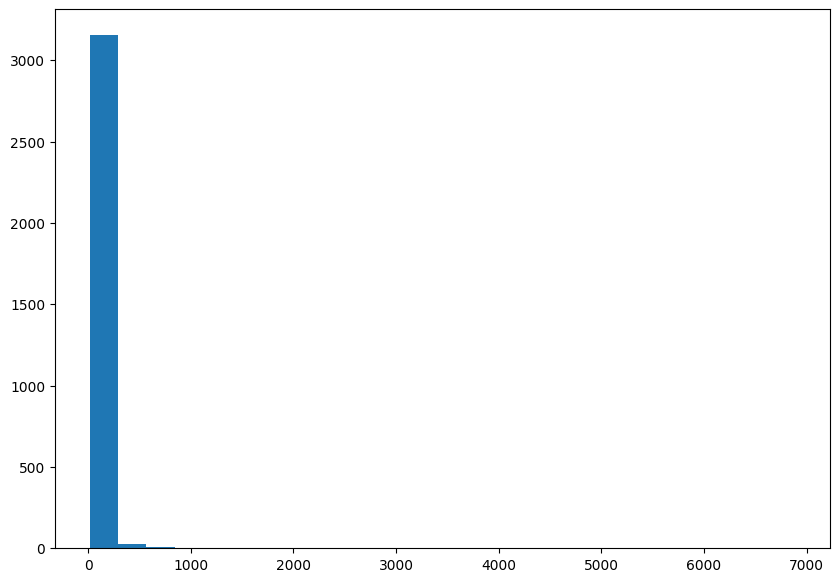

In [122]:
plt.figure(figsize=(10,7))
plt.hist(df['popularity'], bins=25)

## Оценка в среднем

((array([-3.51933543, -3.27674004, -3.14264657, ...,  3.14264657,
          3.27674004,  3.51933543]),
  array([3.852, 4.   , 4.2  , ..., 8.6  , 8.691, 8.707])),
 (0.7648622674520208, 6.778006554307116, 0.9975476409961298))

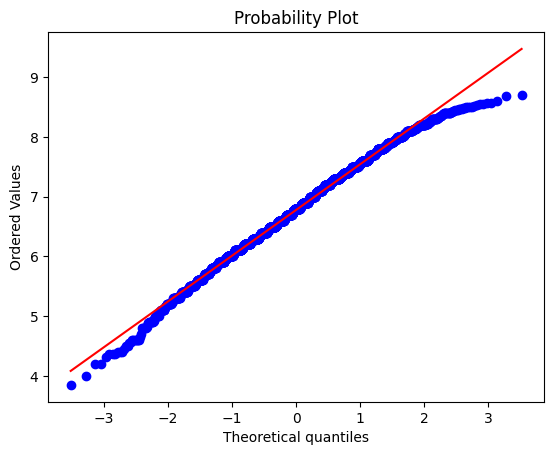

In [123]:
stats.probplot(df['vote_average'], dist="norm", plot=plt)

(array([  1.,   1.,   0.,   2.,   1.,   6.,   3.,   9.,   2.,   7.,   9.,
         11.,  12.,  18.,  28.,  31.,  40.,  18.,  46.,  53.,  65.,  90.,
         89., 124., 135., 136., 144., 169., 149., 155., 162., 149., 135.,
        140., 141., 158., 131., 119., 103.,  71.,  77.,  62.,  53.,  44.,
         41.,  22.,  17.,  16.,   7.,   2.]),
 array([3.852 , 3.9491, 4.0462, 4.1433, 4.2404, 4.3375, 4.4346, 4.5317,
        4.6288, 4.7259, 4.823 , 4.9201, 5.0172, 5.1143, 5.2114, 5.3085,
        5.4056, 5.5027, 5.5998, 5.6969, 5.794 , 5.8911, 5.9882, 6.0853,
        6.1824, 6.2795, 6.3766, 6.4737, 6.5708, 6.6679, 6.765 , 6.8621,
        6.9592, 7.0563, 7.1534, 7.2505, 7.3476, 7.4447, 7.5418, 7.6389,
        7.736 , 7.8331, 7.9302, 8.0273, 8.1244, 8.2215, 8.3186, 8.4157,
        8.5128, 8.6099, 8.707 ]),
 <BarContainer object of 50 artists>)

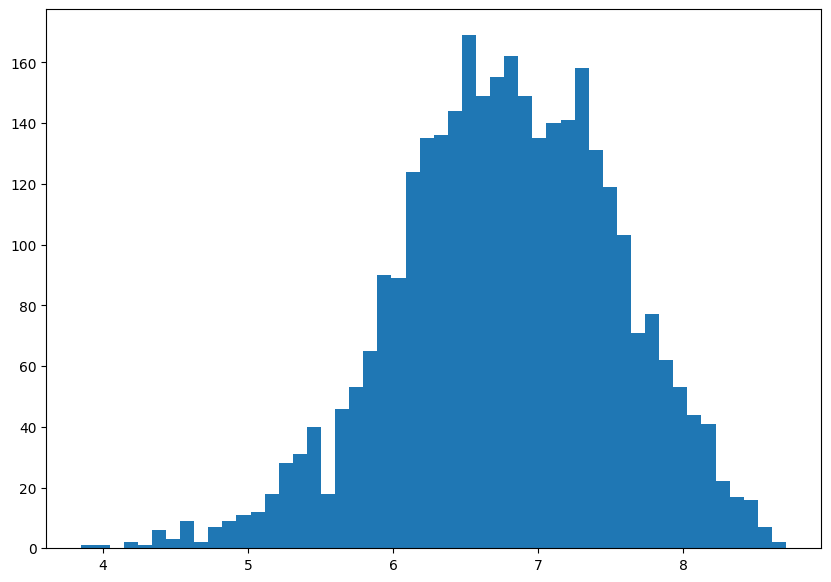

In [124]:
plt.figure(figsize=(10,7))
plt.hist(df['vote_average'], bins=50)

## Количество оценок

(array([457., 496., 438., 314., 274., 227., 156., 126., 115.,  97.,  69.,
         56.,  42.,  40.,  38.,  27.,  33.,  22.,  21.,  14.,  17.,  18.,
          9.,  15.,   8.,  10.,  10.,   5.,  11.,   8.,   7.,   1.,   2.,
          1.,   3.,   4.,   0.,   3.,   2.,   0.,   2.,   0.,   2.,   1.,
          1.,   0.,   0.,   0.,   1.,   1.]),
 array([5.000000e+00, 7.345400e+02, 1.464080e+03, 2.193620e+03,
        2.923160e+03, 3.652700e+03, 4.382240e+03, 5.111780e+03,
        5.841320e+03, 6.570860e+03, 7.300400e+03, 8.029940e+03,
        8.759480e+03, 9.489020e+03, 1.021856e+04, 1.094810e+04,
        1.167764e+04, 1.240718e+04, 1.313672e+04, 1.386626e+04,
        1.459580e+04, 1.532534e+04, 1.605488e+04, 1.678442e+04,
        1.751396e+04, 1.824350e+04, 1.897304e+04, 1.970258e+04,
        2.043212e+04, 2.116166e+04, 2.189120e+04, 2.262074e+04,
        2.335028e+04, 2.407982e+04, 2.480936e+04, 2.553890e+04,
        2.626844e+04, 2.699798e+04, 2.772752e+04, 2.845706e+04,
        2.918660e+

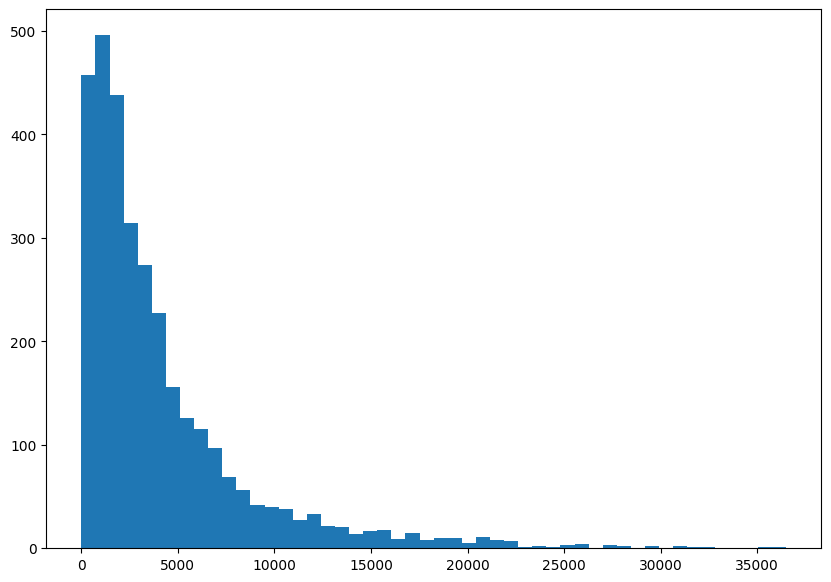

In [125]:
plt.figure(figsize=(10,7))
plt.hist(df['vote_count'], bins=50)

## Вывод

Сборы, бюджет, популярность и количество голосов распределены логарифмически. Прологарифмируем их, чтобы распределение стало ближе к нормальному.

In [126]:
df[['revenue', 'budget', 'popularity', 'vote_count']] = np.log(df[['revenue', 'budget', 'popularity', 'vote_count']])

# Baseline модель

Сначала используем scaler и PCA.

In [127]:
X = df[['vote_average', 'budget', 'popularity', 'vote_count', 'revenue']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components = 2, random_state=42)
X_transformed = pca.fit_transform(X_scaled)

В кажестве baseline решения разобьём данные на случайные группы с произвольным числом кластеров.

In [128]:
num_clusters = 3
random_labels = np.random.randint(0, num_clusters, X_transformed.shape[0])

silhouette = silhouette_score(X_transformed, random_labels)
db_index = davies_bouldin_score(X_transformed, random_labels)
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", db_index)

Silhouette Score: -0.00835533550031787
Davies-Bouldin Index: 37.81152244909472


Метрики далеки от идеала...

# Framework модель

## Определяем оптимальное число кластеров методом локтя

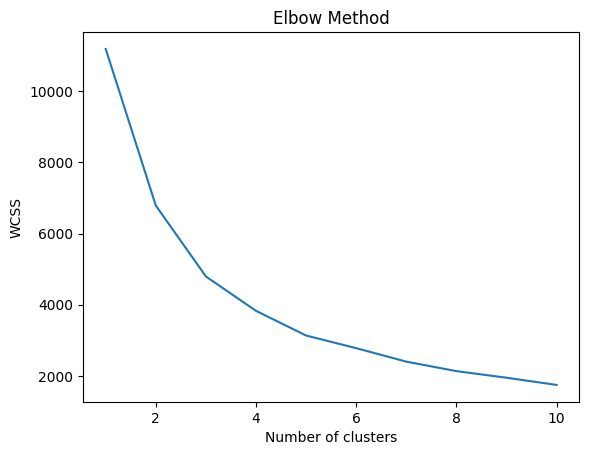

In [129]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300,  random_state=42)
    kmeans.fit(X_transformed)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Модель

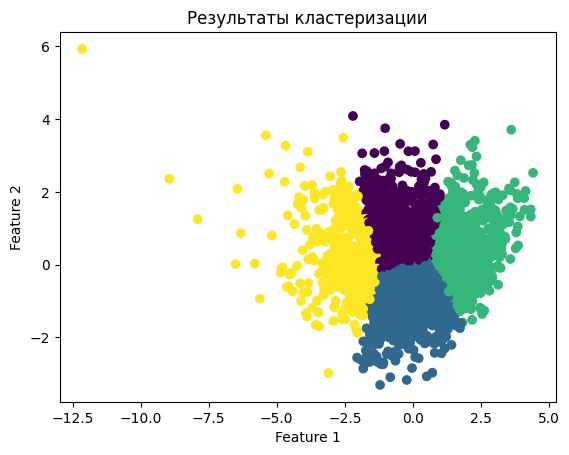

Silhouette Score: 0.347455770711243
Davies-Bouldin Index: 0.9028460707483504


In [130]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=42)
kmeans.fit(X_transformed)

y_kmeans = kmeans.predict(X_transformed)

plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_kmeans)
plt.title('Результаты кластеризации')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

silhouette = silhouette_score(X_transformed, y_kmeans)
db_index = davies_bouldin_score(X_transformed, y_kmeans)
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", db_index)

# Ручная реализация

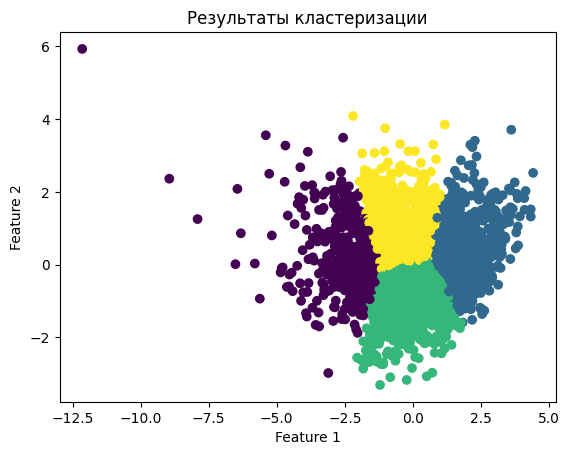

Silhouette Score: 0.3475899081505567
Davies-Bouldin Index: 0.902647815277491


In [131]:
from my_kmeans import MyKMeans

kmeans = MyKMeans(n_clusters=4, max_iter=300)
kmeans.fit(X_transformed)

y_kmeans = kmeans.predict(X_transformed)

plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_kmeans)
plt.title('Результаты кластеризации')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

silhouette = silhouette_score(X_transformed, y_kmeans)
db_index = davies_bouldin_score(X_transformed, y_kmeans)
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", db_index)